In [84]:
#전처리 파일
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import re
import MeCab
import numpy as np
from datetime import datetime
from collections import Counter




fontpath="C:/Users/USER/appData/Local/Microsoft/Windows/Fonts/NanumSquareRoundR.ttf"
data_path= 'C:/Users/USER/text_mining_project/text_mining_project'
font= fm.FontProperties(fname=fontpath, size=9)

pd.options.display.max_rows = 100


In [73]:
#댓글 csv 파일
df_1= pd.read_csv(data_path+'/crawling_1_9_politics.csv')
df_2= pd.read_csv(data_path+'/crawling_10_20_politics.csv')
df_3= pd.read_csv(data_path+'/crawling_20_31_politics.csv')
df_4= pd.read_csv(data_path+'/crawling_4_1_5.csv')
df= pd.concat([df_1, df_2, df_3, df_4])

df= df.drop(columns=df.columns[0])
df_clean= df.dropna(subset=['댓글'])
df_clean.loc[:,'댓글']= df_clean.loc[:,'댓글'].apply(lambda x:x.replace('\n',''))


86363
71577


In [74]:
#전처리
#토큰화
mecab= MeCab.Tagger()
def tokenizing(text):
    node = mecab.parseToNode(text)

    node= node.next
    words=[]
    # 단어만 추출
    
    while node:
        # 노드의 품사 정보가 명사인 경우 리스트에 추가
        if node.feature.startswith(('NNG','NNP')):
            words.append(node.surface)
        # 다음 노드로 이동
        node = node.next
    return words
    

df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))




C:\Users\USER\AppData\Local\Temp\ipykernel_18172\1339089780.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))


In [78]:
#불용어 제거
stop_words= ['때','짓', '당']
def preprocessing(token_list):
    p= re.compile('^[가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\\s]')
    token_list= list(filter(p.match, token_list))
    
    
    
    return [token for token in token_list if not token in stop_words]

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(lambda x:preprocessing(x))
df_clean= df_clean[df_clean['정제 댓글'].map(len)>0]
len(df_clean)

68962

In [79]:
#토큰에 포함된 비속어 및 오타 변경
word_pairs= [
(['국짐','국힘','국짐당'],['국민의힘']),
(['더듬어당','더불어공산당'], ['민주당']),
(['김건히','김거니'],['김건희']),
(['문씨','문가','문재앙','뮨재인','문가놈'],['문재인']),
(['윤재앙','윤씨','윤가','윤석렬','윤캉통','윤석연','윤떡렬','윤패륜','윤두환','윤완용','윤두창','윤틀러','윤정은','윤진핑','윤무능'],['윤석열']),
(['째명','찢재명','찢죄명','찟죄명','찢째명','찟재명','리재명','이재멍','짓재명'],['이재명']),
(['닭근혜','박그네'],['박근혜']),
(['한똥훈','한뚜컹','한덩훈'],['한동훈']),
(['동후니','똥훈이','동훈'],['동훈']),
(['추다르크','추장군'],['추미애']),
(['준떡','준서기'],['준석'])
]


def replace_words(s):
    if isinstance(s, str):
        for pair in word_pairs:
            for word in pair[0]:
                s = s.replace(word, pair[1][0])
        return s
    elif isinstance(s, list):
        return [replace_words(item) for item in s]
    
    else:
        return 

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(replace_words)

### 키워드 별 워드클라우드

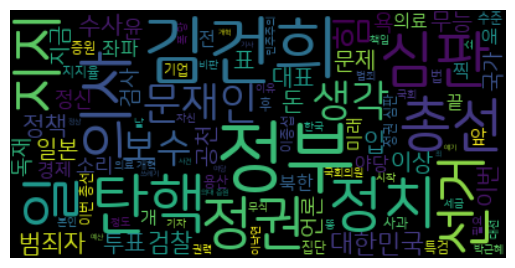

In [93]:
#워드 클라우드 분석
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_gen(df_row, keyword, remove_keywords):
    word_cloud_list=[]
    for i in df_row:
        if keyword in i:
            word_cloud_list.append(i)
    
    #1차원 배열로 변환
    word_cloud_list= sum(word_cloud_list,[])

    #해당 keyword는 리스트에서 제거
    while keyword in word_cloud_list:
        word_cloud_list.remove(keyword)

    for remove_keyword in remove_keywords:
        while remove_keyword in word_cloud_list:
            word_cloud_list.remove(remove_keyword)

    word_cloud=word_cloud=WordCloud(font_path=fontpath,  max_words= 100).generate(' '.join(word_cloud_list))
    return word_cloud

word_cloud_han= wordcloud_gen(df_clean['정제 댓글'], '윤석열',['사람','말','인간','나라','국민','한동훈','이재명','국민의힘', '민주당','조국','대통령'])


plt.imshow(word_cloud_han, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
#기사 날짜, 댓글 dataframe 생성
def date_shft(date):
    datetime_ob= datetime.strptime(str(date), '%Y%m%d')
    return datetime_ob


df_date_comment= df_clean[['기사 날짜','정제 댓글']].copy()
df_date_comment['기사 날짜']= df_date_comment['기사 날짜'].apply(date_shft)



df_date_comment




,기사 날짜,정제 댓글
0,2024-03-01,"[개, 잡범, 전직, 검사, 오금, 검사, 쌍방울, 땡땡이, 인간, 겁]"
1,2024-03-01,"[이재명, 사이비, 교주, 죄, 방송, 토론, 개, 생각]"
2,2024-03-01,"[동훈, 애, 정작, 본인]"
3,2024-03-01,"[ㅈ, ㅅ, 동훈, 말자, 나이]"
5,2024-03-01,"[진영, 매몰, 상식, 합리, 한동훈, 정치, 응원, 김영주, 의원, 국민의힘, 총..."
...,...,...
13892,2024-04-05,"[이천수, 선수, 끝, 포기, 응원, 골수, 좌파, 상종, 인간]"
13893,2024-04-05,[연기자]
13894,2024-04-05,"[건희, 명품, 쇼핑]"
13895,2024-04-05,"[독일, 짝, 나라, 폭, 망, 정부, 거니, 명품, 뇌물, 언론, 쫑]"


### 날짜에 따른 특정 키워드 빈도 분석

In [87]:
#댓글 내 키워드 카운팅 함수
month_days= {2:29,3:31, 4:5}

def keyword_counting(df,keywords):
    target_dates= []
    for month in range(3, 3+2):
        for day in range(1, month_days[month]+1):
            target_dates.append(datetime.strptime(f"2024{month:02d}{day:02d}",'%Y%m%d'))
    date_count= pd.DataFrame(columns= keywords, index= pd.to_datetime([]))
    
    for target_date in target_dates:
        target_date_df= df[df['기사 날짜'] == target_date]
        word_list= sum(target_date_df['정제 댓글'], [])
        keyword_counts=[]
        for keyword in keywords:
            
            counts= word_list.count(keyword)
            keyword_counts.append(counts)
        date_count.loc[target_date]=keyword_counts
    return date_count

date_counts= keyword_counting(df_date_comment, keywords=['이재명','윤석열','김건희','한동훈', '공천','조국','이준석'])


In [88]:
date_counts

,이재명,윤석열,김건희,한동훈,공천,조국,이준석
2024-03-01,74,35,5,9,31,35,0
2024-03-02,73,64,30,20,51,2,12
2024-03-03,109,36,24,18,99,23,4
2024-03-04,171,64,24,159,97,22,43
2024-03-05,71,53,13,37,65,56,7
2024-03-06,112,65,42,42,97,24,20
2024-03-07,84,47,14,31,84,19,6
2024-03-08,107,56,10,98,32,85,8
2024-03-09,128,31,5,29,23,7,3
2024-03-10,123,54,17,23,81,25,3


(19783.0, 19818.0)

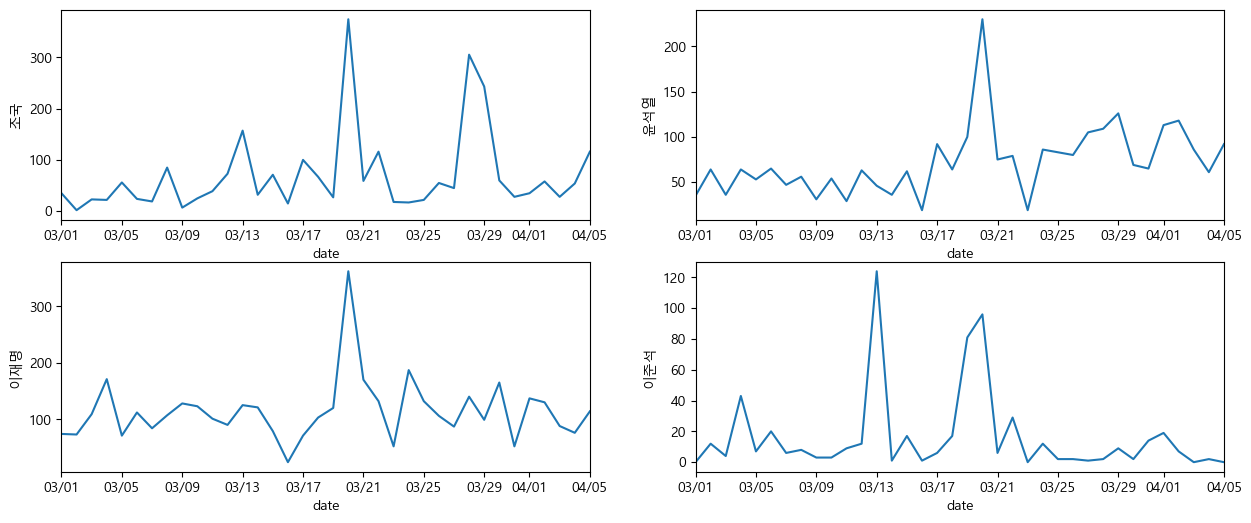

In [95]:
#날짜에 따른 키워드 빈도 변화
import matplotlib.dates as mdates

date_form = mdates.DateFormatter("%m/%d")

fig = plt.figure(figsize=(15, 6)) 
date_counts['date']=date_counts.index


start_date= datetime.strptime('2024-03-01', '%Y-%m-%d')
end_date= datetime.strptime('2024-04-05', '%Y-%m-%d')


plt.rcParams['font.family'] = 'Malgun Gothic'


plt.subplot(221)
sns.lineplot(data=date_counts,x='date',y='조국')
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlim(start_date, end_date)  # x축 범위 설정


plt.subplot(222)
sns.lineplot(data=date_counts,x='date',y='윤석열')
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlim(start_date, end_date)  # x축 범위 설정


plt.subplot(223)
sns.lineplot(data=date_counts,x='date',y='이재명')
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlim(start_date, end_date)  # x축 범위 설정


plt.subplot(224)
sns.lineplot(data=date_counts,x='date',y='이준석')
plt.gca().xaxis.set_major_formatter(date_form)
plt.xlim(start_date, end_date)  # x축 범위 설정




In [100]:


def keyword_top5_each_day_with_exclusion(df, exclude_keywords=[]):

    start_date = df['기사 날짜'].min()
    end_date = df['기사 날짜'].max()
    date_range = pd.date_range(start=start_date, end=end_date)


    top5_results = []


    for target_date in date_range:
        target_date_df = df[df['기사 날짜'] == target_date]


        word_list = sum(target_date_df['정제 댓글'].tolist(), [])


        filtered_words = [word for word in word_list if word not in exclude_keywords]


        word_counts = Counter(filtered_words)
        top5_keywords = word_counts.most_common(5)


        top5_results.append({
            '날짜': target_date,
            '상위 5 키워드': [keyword for keyword, count in top5_keywords],
            '출현 횟수': [count for keyword, count in top5_keywords]
        })


    top5_df = pd.DataFrame(top5_results)
    top5_df['날짜'] = pd.to_datetime(top5_df['날짜'])
    top5_df.set_index('날짜', inplace=True)

    return top5_df

exclude_keywords = ['국민','말','사람','이재명','민주당','한동훈','대통령','국민의힘','나라','인간', '윤석열','조국','문재인','범죄자']  
top5_result_df = keyword_top5_each_day_with_exclusion(df_date_comment, exclude_keywords)


In [101]:
top5_result_df

,상위 5 키워드,출현 횟수
날짜,,
2024-03-01,"[일본, 광주, 총선, 공천, 대한민국]","[82, 52, 31, 31, 28]"
2024-03-02,"[뚝심, 방송, 언론, 정치, 공천]","[130, 118, 64, 59, 51]"
2024-03-03,"[수준, 공천, 정치, 이천수, 원희룡]","[124, 99, 99, 90, 83]"
2024-03-04,"[토론, 정치, 공천, 대표, 선거]","[133, 108, 97, 90, 81]"
2024-03-05,"[의사, 약사, 약, 정부, 처방]","[423, 201, 178, 109, 107]"
2024-03-06,"[의사, 간호사, 돈, 의료, 정치]","[257, 170, 126, 113, 108]"
2024-03-07,"[공천, 선거, 정치, 김신영, 돈]","[84, 65, 60, 52, 51]"
2024-03-08,"[정치, 좌파, 의사, 지지, 일]","[89, 80, 79, 66, 60]"
2024-03-09,"[찍, 수준, 대표, 개딸, 계양]","[353, 75, 74, 60, 51]"


### 제목에 따른 주제 분류

In [ ]:
import pandas as pd
df= pd.read_csv(data_path+'/title_section.csv')
df= df.drop(columns=df.columns[0])

df_clean= df.dropna(subset=['기사제목'])
df_clean.loc[:,'기사제목']= df_clean.loc[:,'기사제목'].apply(lambda x:x.replace('\n',''))

In [ ]:
#전처리
#토큰화
mecab= MeCab.Tagger()
def tokenizing(text):
    node = mecab.parseToNode(text)

    node= node.next
    words=[]
    # 단어만 추출
    
    while node:
        # 노드의 품사 정보가 명사인 경우 리스트에 추가
        if node.feature.startswith(('NNG','NNP')):
            words.append(node.surface)
        # 다음 노드로 이동
        node = node.next
    return words
    

df_clean['기사제목']= df_clean.loc[:, '기사제목'].apply(lambda x:tokenizing(x))

In [ ]:
#불용어 제거
stop_words= ['때','짓', '당']
def preprocessing(token_list):
    p= re.compile('^[가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\\s]')
    token_list= list(filter(p.match, token_list))
    
    
    
    return [token for token in token_list if not token in stop_words]

df_clean['기사제목']= df_clean['기사제목'].apply(lambda x:preprocessing(x))

In [ ]:
# 기사제목을 문자열로 변환
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
df_clean['기사제목'] = df_clean['기사제목'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_clean['기사제목']).toarray()

# 레이블 인코딩
le = LabelEncoder()
y = le.fit_transform(df_clean['분류'])

# train set과 test set으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 훈련
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss') # 'use_label_encoder' 경고를 방지하기 위한 설정
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

### 코사인 유사도 평균 비교

In [102]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


df_1= pd.read_csv(data_path+'/crawling_all_1_20.csv')
df_2= pd.read_csv(data_path+'/crawling_all_21_31.csv')
df_3= pd.read_csv(data_path+'/crawling_all_4_1_5.csv')
df= pd.concat([df_1, df_2, df_3])

df= df.drop(columns=df.columns[0])
df_clean= df.dropna(subset=['댓글'])
df_clean.loc[:,'댓글']= df_clean.loc[:,'댓글'].apply(lambda x:x.replace('\n',''))

#전처리
#토큰화
mecab= MeCab.Tagger()
def tokenizing(text):
    node = mecab.parseToNode(text)

    node= node.next
    words=[]
    # 단어만 추출
    
    while node:
        # 노드의 품사 정보가 명사인 경우 리스트에 추가
        if node.feature.startswith(('NNG','NNP')):
            words.append(node.surface)
        # 다음 노드로 이동
        node = node.next
    return words
    

df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))

#불용어 제거
stop_words= ['때','짓', '당']
def preprocessing(token_list):
    p= re.compile('^[가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\\s]')
    token_list= list(filter(p.match, token_list))
    
    
    
    return [token for token in token_list if not token in stop_words]

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(lambda x:preprocessing(x))

df_clean= df_clean[df_clean['정제 댓글'].map(len)>0]


#토큰에 포함된 비속어 및 오타 변경
word_pairs= [
(['국짐','국힘','국짐당'],['국민의힘']),
(['더듬어당','더불어공산당'], ['민주당']),
(['김건히','김거니'],['김건희']),
(['문씨','문가','문재앙','뮨재인','문가놈'],['문재인']),
(['윤재앙','윤씨','윤가','윤석렬','윤캉통','윤석연','윤떡렬','윤패륜','윤두환','윤완용','윤두창','윤틀러','윤정은','윤진핑','윤무능'],['윤석열']),
(['째명','찢재명','찢죄명','찟죄명','찢째명','찟재명','리재명','이재멍','짓재명'],['이재명']),
(['닭근혜','박그네'],['박근혜']),
(['한똥훈','한뚜컹','한덩훈'],['한동훈']),
(['동후니','똥훈이','동훈'],['동훈']),
(['추다르크','추장군'],['추미애']),
(['준떡','준서기'],['준석'])
]


def replace_words(s):
    if isinstance(s, str):
        for pair in word_pairs:
            for word in pair[0]:
                s = s.replace(word, pair[1][0])
        return s
    elif isinstance(s, list):
        return [replace_words(item) for item in s]
    
    else:
        return 

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(replace_words)





C:\Users\USER\AppData\Local\Temp\ipykernel_18172\1803346043.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))
C:\Users\USER\AppData\Local\Temp\ipykernel_18172\1803346043.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['정제 댓글']= df_clean['정제 댓글'].apply(lambda x:preprocessing(x))


In [107]:
pd.set_option('display.max_rows', 100)
df_clean


,기사 날짜,기사 제목,링크,댓글,공감,비공감,댓글 날짜,분류,정제 댓글
0,20240301,"한동훈, 박민식에 서울 강서을 출마 요청…""승리 위해 헌신해 달라""[2024 총선]",https://n.news.naver.com/mnews/article/014/000...,ㅎㅎ 개잡범이라 전직검사엔 오금이 저릴텐데....검사의 검 자만 들어도 쌍방울...,1,0,2024-03-02,정치,"[개, 잡범, 전직, 검사, 오금, 검사, 쌍방울, 땡땡이, 인간, 겁]"
1,20240301,"한동훈, 박민식에 서울 강서을 출마 요청…""승리 위해 헌신해 달라""[2024 총선]",https://n.news.naver.com/mnews/article/014/000...,이재명 사이비 교주 죄가 많아서 생방송 토론에 나오겠나 개쪽팔려서 나올 생각...,2,3,2024-03-02,정치,"[이재명, 사이비, 교주, 죄, 방송, 토론, 개, 생각]"
2,20240301,"한동훈, 박민식에 서울 강서을 출마 요청…""승리 위해 헌신해 달라""[2024 총선]",https://n.news.naver.com/mnews/article/014/000...,동훈이 같은 애들은 정작 본인은 안나감 ㅋㅋㅋㅋㅋㅋㅋ,0,2,2024-03-02,정치,"[동훈, 애, 정작, 본인]"
3,20240301,"한동훈, 박민식에 서울 강서을 출마 요청…""승리 위해 헌신해 달라""[2024 총선]",https://n.news.naver.com/mnews/article/014/000...,저놈은 진짜 생긴거 부터가 ㅈㅅ없다 동훈아 깐죽대지좀 말자 나이를 어디로 먹었니,1,4,2024-03-02,정치,"[ㅈ, ㅅ, 동훈, 말자, 나이]"
5,20240301,"한동훈 ""함께 정치 하고 싶다""…김영주 ""늦지 않게 답하겠다""[2024 총선]",https://n.news.naver.com/mnews/article/014/000...,진영에 매몰되지 않고 상식적이고 합리적인 한동훈의 정치 응원합니다. 김영주 의원님 ...,153,44,2024-03-01,정치,"[진영, 매몰, 상식, 합리, 한동훈, 정치, 응원, 김영주, 의원, 국민의힘, 총..."
...,...,...,...,...,...,...,...,...,...
68626,20240331,"""당사자인 본인은 입 닫고.."" 결별 알린 한소희, 류준열도 저격?",https://n.news.naver.com/mnews/article/014/000...,혜리는 진짜 이번에 완전 비호감됨. 걍 툭 던져놓고 다른사람들 이미지 다 배려놓고 ...,0,7,2024-03-31,사회,"[혜리, 이번, 호감, 사람, 이미지, 인간, 관계, 사람, 오해, 이상, 유언비어..."
68627,20240331,"""당사자인 본인은 입 닫고.."" 결별 알린 한소희, 류준열도 저격?",https://n.news.naver.com/mnews/article/014/000...,혜리 목적 달성했네~ 한소희 멋지다 류준열처럼 찌질한 놈 만나지 말고 내가 다 속...,0,10,2024-03-31,사회,"[혜리, 목적, 달성, 소희, 류준열, 찌질, 속, 혜리, 류준열, 끝, 남, 진상..."
68628,20240331,"""당사자인 본인은 입 닫고.."" 결별 알린 한소희, 류준열도 저격?",https://n.news.naver.com/mnews/article/014/000...,"혜리도나쁘고,준열이는더나쁘고",2,14,2024-03-31,사회,[혜리]
68630,20240331,"""당사자인 본인은 입 닫고.."" 결별 알린 한소희, 류준열도 저격?",https://n.news.naver.com/mnews/article/014/000...,한소희는 여배로선 드물게 연기.액션.장르안가리고 모든걸 소화가능한 몇안되는 배우자산...,18,44,2024-03-31,사회,"[한소희, 여배, 연기, 액션, 장르, 소화, 가능, 배우, 자산, 개인사, 마녀,..."


In [ ]:
df_politic_100= df_clean[df_clean['분류']=='정치'].sample(100, random_state=5)[['댓글','정제 댓글','분류']]
df_clean= df_clean.drop(df_politic_100.index)
df_world_100= df_clean[df_clean['분류']=='세계'].sample(100, random_state=5)[['댓글','정제 댓글','분류']]
df_IT_100= df_clean[df_clean['분류']=='IT'].sample(100, random_state=5)[['댓글','정제 댓글','분류']]
df_eco_100= df_clean[df_clean['분류']=='경제'].sample(100, random_state=5)[['댓글','정제 댓글','분류']]
df_soci_100= df_clean[df_clean['분류']=='사회'].sample(100, random_state=5)[['댓글','정제 댓글','분류']]
df_politic_5000= df_clean[df_clean['분류']=='정치'].sample(10000, random_state=5)[['댓글','정제 댓글','분류']]


df_contrast= pd.concat([df_politic_100,df_soci_100,df_world_100,df_eco_100,df_IT_100])

df_all= pd.concat([df_politic_5000,df_politic_100,df_soci_100,df_world_100,df_eco_100,df_IT_100])
df_all

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity



docs = [' '.join(doc) for doc in df_all['정제 댓글']]

count_vectorizer = CountVectorizer()
feature_vect = count_vectorizer.fit_transform(docs)

politics_count = len(df_politic_5000)
feature_politics = feature_vect[:politics_count]

def mean_cos_sim(feature_politics, feature_contrast):
    
    cosine_sim_scores = cosine_similarity(feature_politics, feature_contrast)
   
    mean_cos_sim_score = np.mean(cosine_sim_scores, axis=0)
    return mean_cos_sim_score


feature_contrast = feature_vect[politics_count:]


mean_cos_similars = mean_cos_sim(feature_politics, feature_contrast)

df_contrast['cosine_sim'] = mean_cos_similars

In [ ]:
pd.set_option('display.max_rows',None)
df_contrast.sort_values('cosine_sim', ascending=True)

### 댓글에 따른 기사 클러스터링 및 분류

In [ ]:
#댓글 csv 파일
df= pd.read_csv(data_path+'/crawling_all_1_9.csv')
df= df.drop(columns=df.columns[0])

df_clean= df.dropna(subset=['댓글'])
df_clean.loc[:,'댓글']= df_clean.loc[:,'댓글'].apply(lambda x:x.replace('\n',''))

In [ ]:
#전처리
#토큰화
mecab= MeCab.Tagger()
def tokenizing(text):
    node = mecab.parseToNode(text)

    node= node.next
    words=[]
    # 단어만 추출
    
    while node:
        # 노드의 품사 정보가 명사인 경우 리스트에 추가
        if node.feature.startswith(('NNG','NNP')):
            words.append(node.surface)
        # 다음 노드로 이동
        node = node.next
    return words
    

df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))

In [ ]:
#불용어 제거
stop_words= ['때','짓', '당']
def preprocessing(token_list):
    p= re.compile('^[가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\\s]')
    token_list= list(filter(p.match, token_list))
    
    
    
    return [token for token in token_list if not token in stop_words]

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(lambda x:preprocessing(x))

In [ ]:
#토큰에 포함된 비속어 및 오타 변경
word_pairs= [
(['국짐','국힘','국짐당'],['국민의힘']),
(['더듬어당','더불어공산당'], ['민주당']),
(['김건히','김거니'],['김건희']),
(['문씨','문가','문재앙','뮨재인','문가놈'],['문재인']),
(['윤재앙','윤씨','윤가','윤석렬','윤캉통','윤석연','윤떡렬','윤패륜','윤두환','윤완용','윤두창','윤틀러','윤정은','윤진핑','윤무능'],['윤석열']),
(['째명','찢재명','찢죄명','찟죄명','찢째명','찟재명','리재명','이재멍','짓재명'],['이재명']),
(['닭근혜','박그네'],['박근혜']),
(['한똥훈','한뚜컹','한덩훈'],['한동훈']),
(['동후니','똥훈이','동훈'],['동훈']),
(['추다르크','추장군'],['추미애']),
(['준떡','준서기'],['준석'])
]


def replace_words(s):
    if isinstance(s, str):
        for pair in word_pairs:
            for word in pair[0]:
                s = s.replace(word, pair[1][0])
        return s
    elif isinstance(s, list):
        return [replace_words(item) for item in s]
    
    else:
        return 

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(replace_words)

In [ ]:
df_clean
df_cluster= df_clean[['댓글','정제 댓글','분류']]



In [ ]:
#문서 임베딩
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
docs= [''.join(doc) for doc in df_cluster['정제 댓글']]
count_vectorizer= CountVectorizer()
count_matrix= count_vectorizer.fit_transform(docs)


In [ ]:
#kmeans
from sklearn.cluster import KMeans
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(count_matrix)
labels = kmeans.labels_


In [ ]:
from sklearn.cluster import DBSCAN

clustering= DBSCAN(eps=0.5 ,min_samples=10).fit(count_matrix)


labels= clustering.labels_


In [ ]:
np.unique(labels)

In [ ]:
df_cluster['라벨']= labels

In [ ]:
df_cluster[df_cluster['라벨']==0]

### LDA

In [ ]:
#LDA
import pandas as pd
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import MeCab


df= pd.read_csv(data_path+'/crawling_10_20.csv')
df= df.drop(columns=df.columns[0])

df_clean= df.dropna(subset=['댓글'])
df_clean.loc[:,'댓글']= df_clean.loc[:,'댓글'].apply(lambda x:x.replace('\n',''))

In [ ]:
#전처리
#토큰화
mecab= MeCab.Tagger()
def tokenizing(text):
    node = mecab.parseToNode(text)

    node= node.next
    words=[]
    # 단어만 추출
    
    while node:
        # 노드의 품사 정보가 명사인 경우 리스트에 추가
        if node.feature.startswith(('NNG','NNP')):
            words.append(node.surface)
        # 다음 노드로 이동
        node = node.next
    return words
    

df_clean['정제 댓글']= df_clean.loc[:, '댓글'].apply(lambda x:tokenizing(x))

In [ ]:
#불용어 제거
stop_words= ['때','짓', '당']
def preprocessing(token_list):
    p= re.compile('^[가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z\\s]')
    token_list= list(filter(p.match, token_list))
    
    
    
    return [token for token in token_list if not token in stop_words]

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(lambda x:preprocessing(x))

In [ ]:
#토큰에 포함된 비속어 및 오타 변경
word_pairs= [
(['국짐','국힘','국짐당'],['국민의힘']),
(['더듬어당','더불어공산당'], ['민주당']),
(['김건히','김거니'],['김건희']),
(['문씨','문가','문재앙','뮨재인','문가놈'],['문재인']),
(['윤재앙','윤씨','윤가','윤석렬','윤캉통','윤석연','윤떡렬','윤패륜','윤두환','윤완용','윤두창','윤틀러','윤정은','윤진핑','윤무능'],['윤석열']),
(['째명','찢재명','찢죄명','찟죄명','찢째명','찟재명','리재명','이재멍','짓재명'],['이재명']),
(['닭근혜','박그네'],['박근혜']),
(['한똥훈','한뚜컹','한덩훈'],['한동훈']),
(['동후니','똥훈이','동훈'],['동훈']),
(['추다르크','추장군'],['추미애']),
(['준떡','준서기'],['준석'])
]


def replace_words(s):
    if isinstance(s, str):
        for pair in word_pairs:
            for word in pair[0]:
                s = s.replace(word, pair[1][0])
        return s
    elif isinstance(s, list):
        return [replace_words(item) for item in s]
    
    else:
        return 

df_clean['정제 댓글']= df_clean['정제 댓글'].apply(replace_words)

In [ ]:
texts= df_clean['정제 댓글'].tolist()

dictionary= corpora.Dictionary(texts)
corpus= [dictionary.doc2bow(text) for text in texts]
num_topics = 3  # 추출하고자 하는 주제의 수, 상황에 따라 조정
passes = 15  
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# 결과 출력
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=5):
    print(f'Topic {i}: {topic}\n')

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)